# Daily Electricity Consumption Analysis and Forecasting

## Part 1: ARIMA

In this notebook we model electricity consumption based on historic trends using Auto Regressive Integrated Moving Average models. The theory behind these models is explained by Professor Robert Nau, of Duke University, and can be found here:
http://people.duke.edu/~rnau/411home.htm

This notebook also contains an exploration of the largest errors made by the forecasting model, in order to determine which additional data should be included in a better model.


## Importing Libraries and Helper Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as MAE
from statsmodels.tsa.statespace.sarimax import SARIMAX

from Time_series_helpers import show_acf_plots

## Loading the data
Note that this is data that has already been cleaned up in another notebook to deal with issues like duplicate values arising from time change with dailight saving time, etc...
See the notebook Electricity Consumption: Basic EDA and Data Cleaning for details and code.

In [2]:
elec = pd.read_csv('data/processed/elec_clean.csv', index_col=[0], parse_dates=True)
#resampling the data so that it is daily rather than hourly
daily_elec = elec.resample('D').sum()
#removing the last value which doesn't contain a full day for consistency
daily_elec = daily_elec.iloc[:-1,]

<AxesSubplot:title={'center':'Daily Electricity Consumption (MW), US East, 2002-2018'}, xlabel='Datetime'>

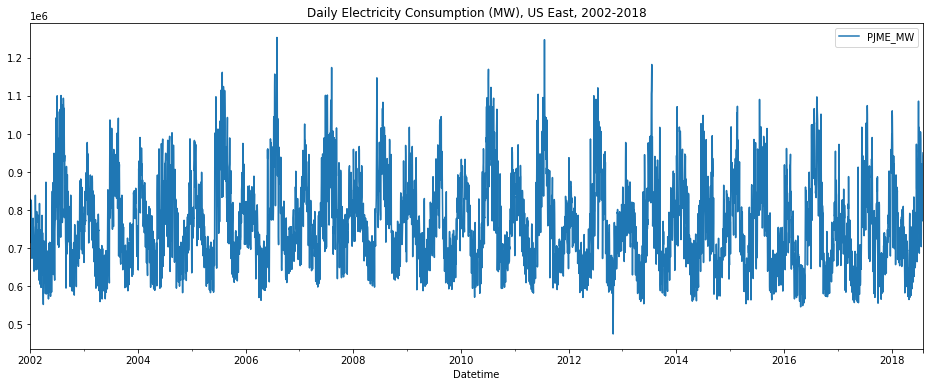

In [3]:
daily_elec.plot(figsize = (16,6), title = 'Daily Electricity Consumption (MW), US East, 2002-2018')

## Basic summary statistics about the data

In [4]:
daily_elec.describe()

#we see a mean of approx 7.7 M MW, with a standard deviation of 1.13 M MW;

,PJME_MW
count,6.058000e+03
mean,7.697675e+05
std,1.126192e+05
min,4.744570e+05
25%,6.870612e+05
50%,7.525230e+05
75%,8.392702e+05
max,1.253516e+06


<AxesSubplot:title={'center':'Histogram of daily electricity consumption frequencies'}, ylabel='Frequency'>

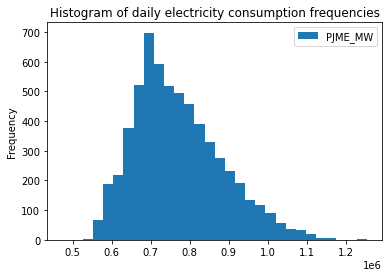

In [5]:
daily_elec.plot(kind='hist', bins=30, title = 'Histogram of daily electricity consumption frequencies')

What we see looks more like a log_normal distribution than like a normal distribution; let's try a log transformation to see what the histogram of values looks like afterwards.

<AxesSubplot:title={'center':'Histogram of daily electricity consumption frequencies, log transformed'}, ylabel='Frequency'>

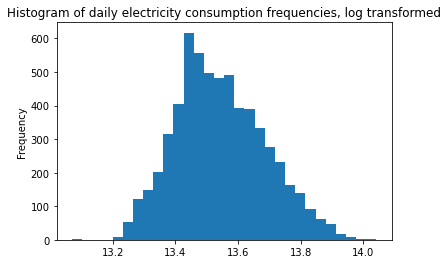

In [6]:
daily_elec['log_electric_consumption'] = daily_elec.PJME_MW.apply(np.log)

daily_elec.log_electric_consumption.plot(kind='hist', bins=30, 
                                         title = 'Histogram of daily electricity consumption frequencies, log transformed')

This looks more like a normal distribution, even though the mode is lower than the mean; outliers on the bottom end become more clearly visible on this histogram, we should investigate these outliers.

### Analysis of outliers

In [7]:
daily_elec[daily_elec.log_electric_consumption<13.2]

,PJME_MW,log_electric_consumption
Datetime,,
2012-10-30,474457.0,13.069926


There seems to be a single outlier on the bottom end, on 30/10/2012; a quick google search shows that this was the day after Hurricane Sandy. Power cuts can be expected after major natural disasters, which would explain low electric consumption.

Let's have a closer look at this period.

In [8]:
daily_elec[(daily_elec.index> '2012-10-26') & (daily_elec.index < '2012-11-05')]

,PJME_MW,log_electric_consumption
Datetime,,
2012-10-27,601189.0,13.306665
2012-10-28,602158.0,13.308275
2012-10-29,602962.0,13.309609
2012-10-30,474457.0,13.069926
2012-10-31,566452.0,13.247148
2012-11-01,610851.0,13.322608
2012-11-02,630160.0,13.353729
2012-11-03,617956.0,13.334173
2012-11-04,601550.0,13.307265


We can see that the electricity consumption statistics seem normal before october 30th and that they quickly went back to normal after, as all raw values are inside the 600k-767k range. Therefore, it would make sense to adjust these outliers to improve our model.  

Note that the fact that other catastrophic events which disrupt electrity supply could occur is irrelevant to our prediction exercise: what we want to model is electricity demand, and reduced electricity use due to power cuts is a failure of the system which shouldn't be planned for.

Below, we try to find a good value to impute.

In [9]:
daily_elec[daily_elec.index == '2012-10-31'].index.dayofweek 

Int64Index([2], dtype='int64', name='Datetime')

The observations which need to be changed occured on a Monday & Tuesday. Therefore, we cannot just fill in the value with the value of the previous day, as that was a weekend and we know that weekends have lower electricity demand. Filling in the value of the wednesday after makes more sense.

In [10]:
daily_elec.loc['2012-10-30','PJME_MW'] = 611000
daily_elec.loc['2012-10-31','PJME_MW'] = 611000

Looking at outliers on the top end:

In [11]:
daily_elec[daily_elec.log_electric_consumption>14]

,PJME_MW,log_electric_consumption
Datetime,,
2006-08-01,1205397.0,14.002320
2006-08-02,1253516.0,14.041463
2006-08-03,1243764.0,14.033653
2011-07-22,1247699.0,14.036812


The fact that there were 3 consecutive days of very high energy consumption in early August 2006 means we can probably attribute this to the weather.

In [12]:
daily_elec[(daily_elec.index > "2011-07-19") & (daily_elec.index < '2011-07-25')]

,PJME_MW,log_electric_consumption
Datetime,,
2011-07-20,1080217.0,13.892673
2011-07-21,1175477.0,13.977185
2011-07-22,1247699.0,14.036812
2011-07-23,1151439.0,13.956523
2011-07-24,1065999.0,13.879423


Similarly, the high energy consumption on 22 July doesn't look so much like an outlier, it's just the peak day of a period of high energy demand which is probably due to hot weather: we'll look more deeply into weather in another notebook.

Below, we re-apply the log transformation to imputed data so that log values are consistent, and plot the histogram to check.

<AxesSubplot:title={'center':'Histogram of daily electricity consumption frequencies, log transformed'}, ylabel='Frequency'>

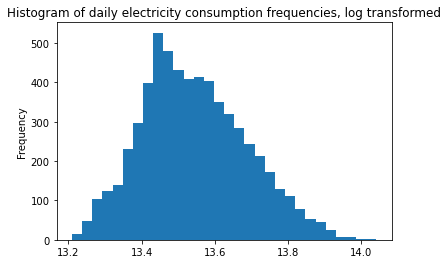

In [13]:
daily_elec['log_electric_consumption'] = daily_elec.PJME_MW.apply(np.log)
daily_elec.log_electric_consumption.plot(kind='hist', bins=30, 
                                         title = 'Histogram of daily electricity consumption frequencies, log transformed')

We now have daily electricity consumption data that looks clean enough and normal enough to work with. We save the file for later use with other models.

In [14]:
daily_elec.to_csv('data/processed/daily_elec.csv')

## Preparing the data for ARIMA

2018 is an incomplete year, which we won't use to test our model. Predicting far ahead is complicated, so we'll keep only 2 full years for testing, 2016 and 2017.

Ten full years should be enough to capture all of the trends we want to capture, 2006 to 2015 seems like a good period to use for training. 

This leaves us 4 years, from 2002 to 2005, on which to calculate general seasonal trends. This is done because ARIMA models are not designed to deal with data that has seasonal or cyclical components. Note that while the statsmodels package provides a function called seasonal_decompose, this function did not work well at all on our data, as it was unable to differentiate between trend, seasonality, and noise. Therefore, manual detrending was necessary. The seasonal detrending will take the moving average over 28 days (so that exactly 4 weekends are always included in the calculation) for aperiod of a few years.

### Calculating seasonal trends from the first 4 years of data

In [15]:
#getting a slice of the data
first_4_years = daily_elec.copy()
first_4_years = first_4_years[first_4_years.index < '2006']
#adding day of year as a column
first_4_years['day_ofyr'] = first_4_years.index.dayofyear
#calculating a centered rolling mean
first_4_years['roll_mean'] = first_4_years['log_electric_consumption'].rolling(window=28, center=True).mean()
#dropping missing values (first and last 14 days have no rolling mean value)
first_4_years.dropna(inplace=True)
#checking
first_4_years.info() 
#saving the dataframe for future use
first_4_years.to_csv('data/processed/first_4y.csv')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1434 entries, 2002-01-15 to 2005-12-18
Freq: D
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PJME_MW                   1434 non-null   float64
 1   log_electric_consumption  1434 non-null   float64
 2   day_ofyr                  1434 non-null   int64  
 3   roll_mean                 1434 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 56.0 KB


The data now starts on 15th of January, and ends on 18th of December, but that's alright since we still have 3 years of data on which we calculate a mean of a rolling mean for the first and last 14 days of the year.
Below, we calculate the mean value of the expected energy consumption trend for each day of the year, i.e. the mean of the rolling mean centered on that day.

<AxesSubplot:title={'center':'Daily Smoothed Electricity Consumption Trend, 2002-2006'}, xlabel='day_ofyr'>

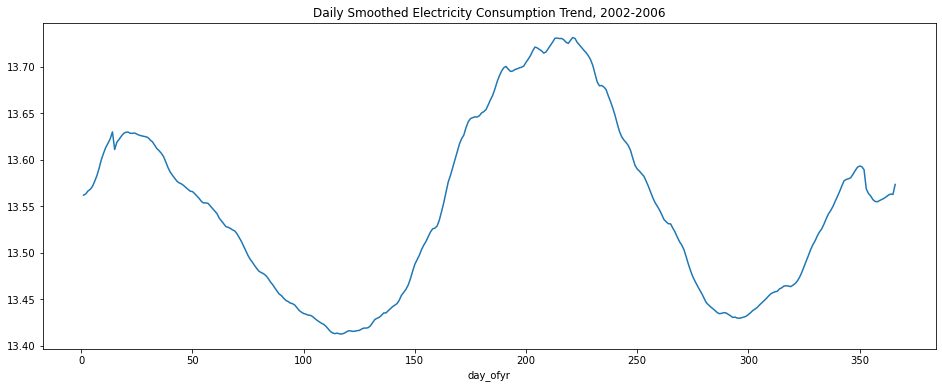

In [16]:
day_trend = first_4_years.groupby('day_ofyr').roll_mean.mean()

day_trend.plot(figsize = (16,6), title = 'Daily Smoothed Electricity Consumption Trend, 2002-2006')

The result that we get is quite smooth and should be a pretty good representation of trends; however, we can note a break in
the smoothness, which might come from the general differences in years; it would be preferable if this weren't there.
We don't touch the end part of the series, as some of the dip at the end of the year might be due to reduced industrial activity during the Christmas season. However, the discontinuity at the left of the graph is exactly at day 15, which exactly corresponds to the connection point, so a second smoothing makes sense for this day. 

In [17]:
day_trend[15] = (day_trend[14]+day_trend[16])/2

#putting the day_trend variable as a dictionnary for use in a function
day_trend_dict = day_trend.to_dict()
#saving the day trend series for future use
day_trend.to_csv('data/processed/day_trend.csv')

### Looking at the detrended plot of the training set

In [18]:
#adding the necessary variables in the dataframe to detrend the data
full_day_data = daily_elec.copy()
full_day_data['day_of_yr'] = full_day_data.index.dayofyear
full_day_data['adjustment_value'] = full_day_data['day_of_yr'].apply(lambda d: day_trend_dict[d])
full_day_data['adjusted_elec'] = full_day_data['log_electric_consumption'] - full_day_data['adjustment_value']

#splitting the data into training and test set
train, test = full_day_data[(full_day_data.index >= '2006')& (full_day_data.index < '2016')] , \
full_day_data[full_day_data.index >= '2016']

<AxesSubplot:title={'center':'Daily Electric Consumption minus expected trend, 2006-2015'}, xlabel='Datetime'>

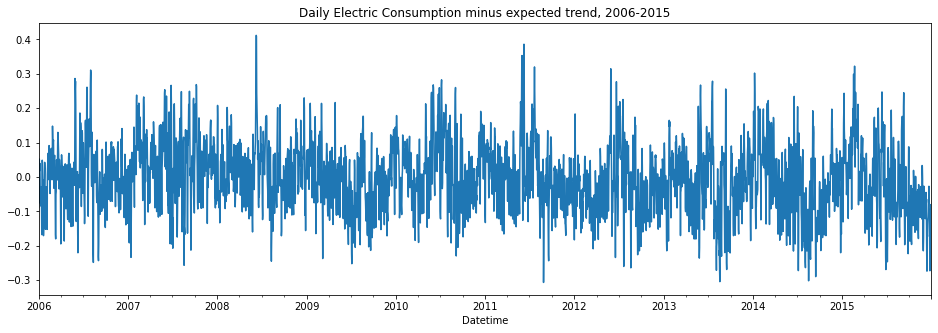

In [19]:
train['adjusted_elec'].plot(figsize=(16,5), title = 'Daily Electric Consumption minus expected trend, 2006-2015')

What we see looks noisy and de-trended, but there still seems to be some need for differencing as the data seems to go consistently up then down at different periods (random walk type behavior). 
It doesn't make sense to difference by one day, because if we do, weekends will have extremely low values, and mondays extremely high values; so we need to difference by one week.

<AxesSubplot:title={'center':'Detrended daily electric consumption, with 1 week differencing, 2006-2015'}, xlabel='Datetime'>

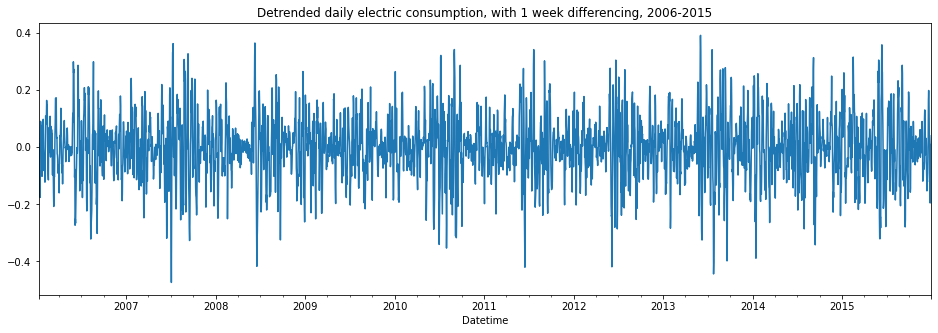

In [20]:
adj_diffed_daily_elec = train['adjusted_elec'] - train['adjusted_elec'].shift(7)

adj_diffed_daily_elec.dropna(inplace=True)
adj_diffed_daily_elec.plot(figsize=(16,5), title = 'Detrended daily electric consumption, with 1 week differencing, 2006-2015')

We now have something that looks like pure white noise; let's check this assumption with an Augmented Dickey Fuller test.

In [21]:
adfuller(adj_diffed_daily_elec)

(-14.95138750011919,
 1.2788128073641398e-27,
 29,
 3615,
 {'1%': -3.4321602211641724,
  '5%': -2.8623398545767365,
  '10%': -2.56719577511483},
 -10955.461815888924)

Our series is stationary, with an extremely low p-value (the second value in the output of the test above). We now need to look at its auto-correlation and partial auto-correlation plots in order to determine the order of the ARIMA model to use.

### Plotting the Autocorrelation and Partial Autocorrelation of the differentiated time series

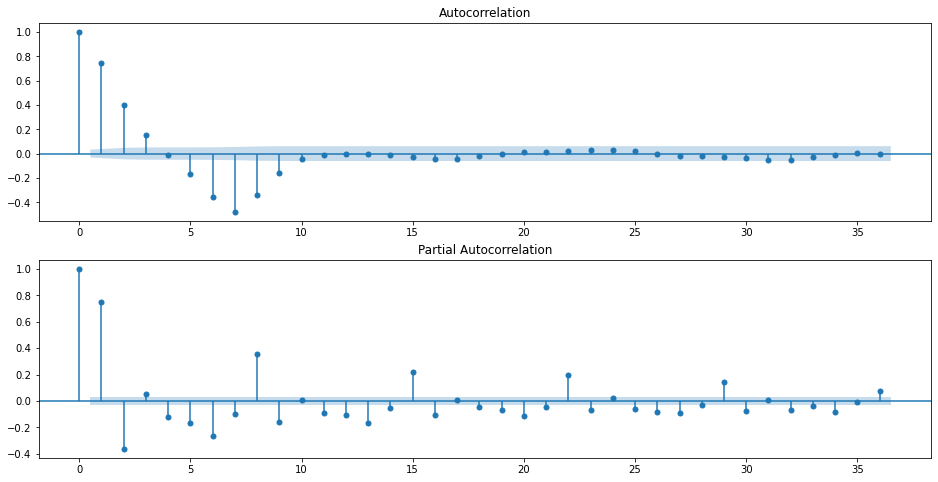

In [22]:
show_acf_plots(adj_diffed_daily_elec)

Auto-correlation decays gradually until it becomes insignificant at day 4, but then becomes significantly negative at day 7, which corresponds to the differencing that we did; this means our series might be over-differenced. This means that we should try not differencing, and instead rely on an AR factor at the weekly level to capture the weekly ''seasonality''.

### Looking at the Augmented Dickey Fuller test statistics and ACF plots for the simple detrended time series

In [23]:
adfuller(train['adjusted_elec'])

(-7.400228683644722,
 7.589279928619017e-11,
 29,
 3622,
 {'1%': -3.4321567201852456,
  '5%': -2.862338308122449,
  '10%': -2.5671949518327932},
 -11021.845224140354)

Without differencing, our series is already stationary enough, which means we can use the seasonal ARIMA model directly on this series.

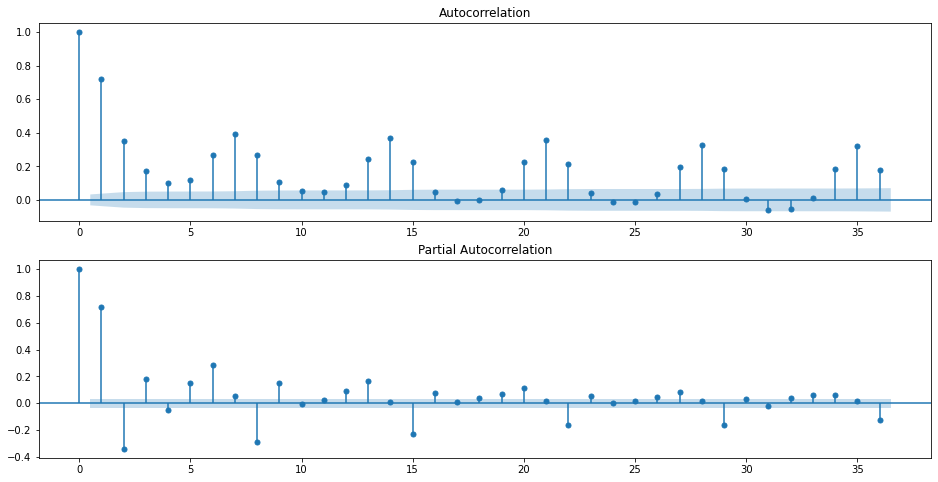

In [24]:
show_acf_plots(train['adjusted_elec']) 

We see autocorrelation gradually decaying but jumping back up at multiples of 7, while partial autocorrelation is significantly negative at every multiple of 7 + 1; a seasonal ARIMA model seems necessary, in order to be able to take into account both near term autocorrelation and autocorrelation related to weekday effects.

### Fitting a basic AR model without seasonal component

Below, we test a basic AR model, without a seasonal component. The goal is to get rid of residual autocorrelation that is not related to weekly effects. We test this model with p parameters of 1, 2 and 3, to see if the model gets better as p increases, while being able to identify the simplest possible model that captures the trend.

AIC of SARIMA model with order (1,0,0): -9099.54111799764
ACF and PACF plots for AR order 1


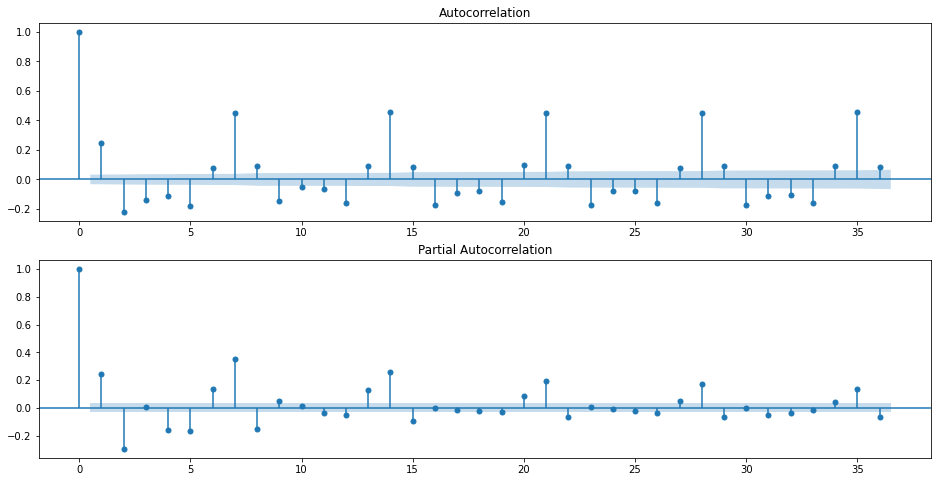

AIC of SARIMA model with order (2,0,0): -9547.563446856202
ACF and PACF plots for AR order 2


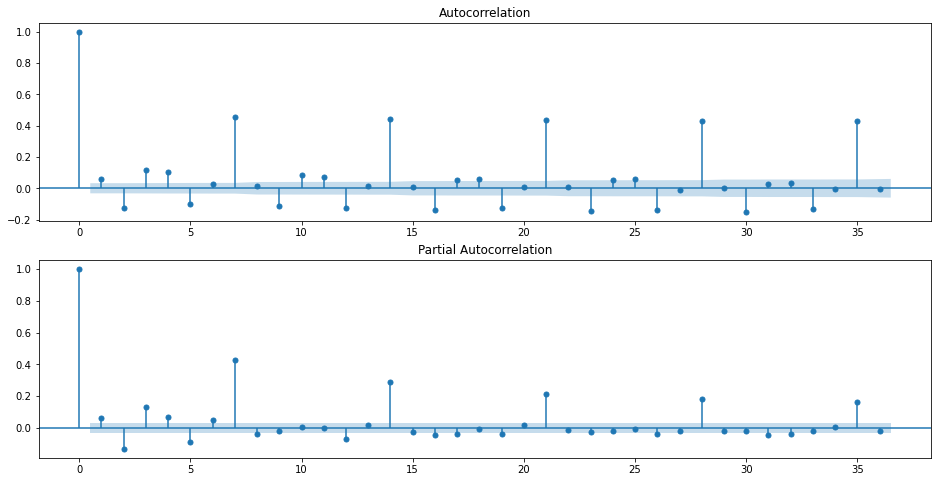

AIC of SARIMA model with order (3,0,0): -9663.93874728886
ACF and PACF plots for AR order 3


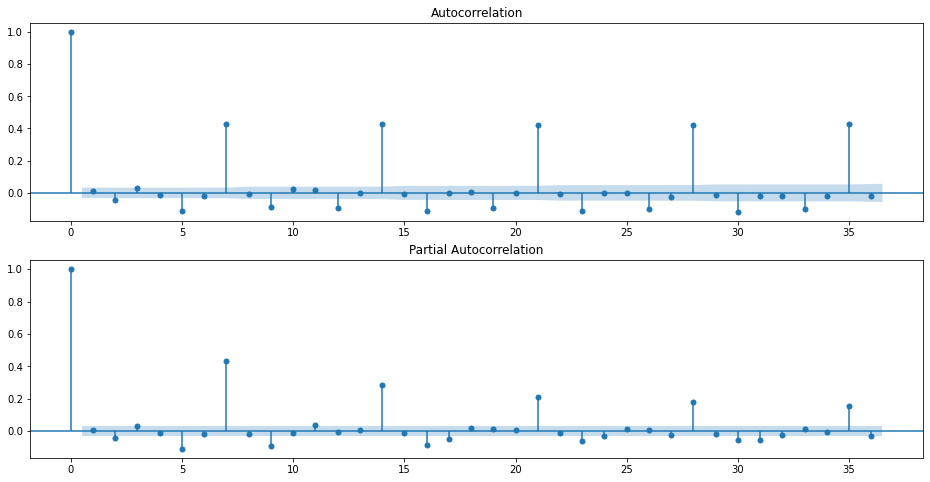

In [25]:
for x in range(1,4):
    base_model = ARIMA(train['adjusted_elec'], order = (x,0,0))
    base_model_fit = base_model.fit()
    print("AIC of SARIMA model with order ({},0,0): {}".format(x, base_model_fit.aic))
    print('ACF and PACF plots for AR order {}'.format(x))
    show_acf_plots(base_model_fit.resid)

As we can see above, a simple AR model, with no differencing and no moving average term, is enough to make predictions for which the autocorrelation of residual errors is only really significant at lags with multiples of 7, which represent weekly effects. The slightly significant autocorrelation of residuals at lags 5 and 9 are probably effects of weekday to weekend differences, and we can expect them to dissapear as we introduce a seasonal component to the model.

### Introducing a seasonal order to the model

Now that we have a model which has captured the non weekly trend, we add the seasonal component.   
In order to do so, we follow the recommendations made by Professor Robert Nau in his paper on seasonal ARIMA models and try only the following seasonal orders for the SARIMA model: 1,0,0; 2,0,0; 1,1,0; 2,1,0; 0,0,1; and 0,1,1; the last term, 7, corresponds to the weekly cycle.

AIC of SARIMA model with order (3,0,0) and seasonal_order (1, 0, 0, 7): -10442.141524124683


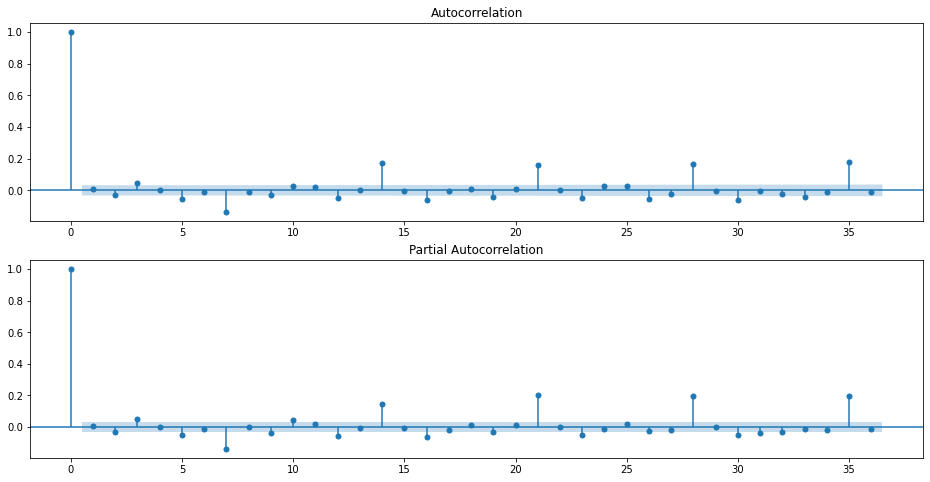

AIC of SARIMA model with order (3,0,0) and seasonal_order (2, 0, 0, 7): -10795.603475393284


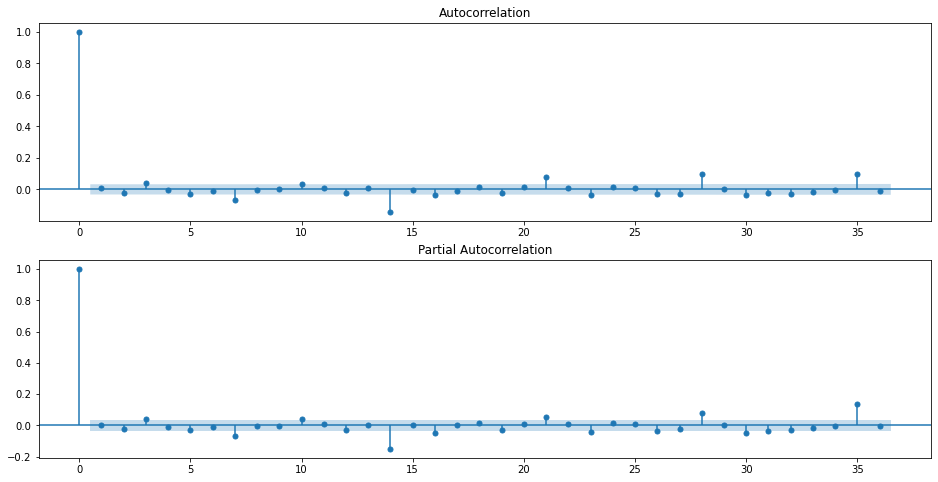

AIC of SARIMA model with order (3,0,0) and seasonal_order (1, 1, 0, 7): -10280.870624564772


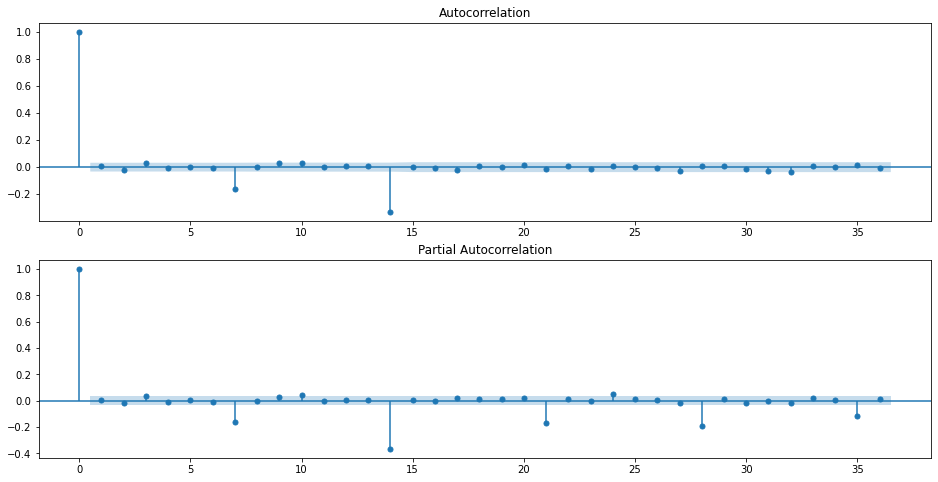

AIC of SARIMA model with order (3,0,0) and seasonal_order (2, 1, 0, 7): -10683.53503797707


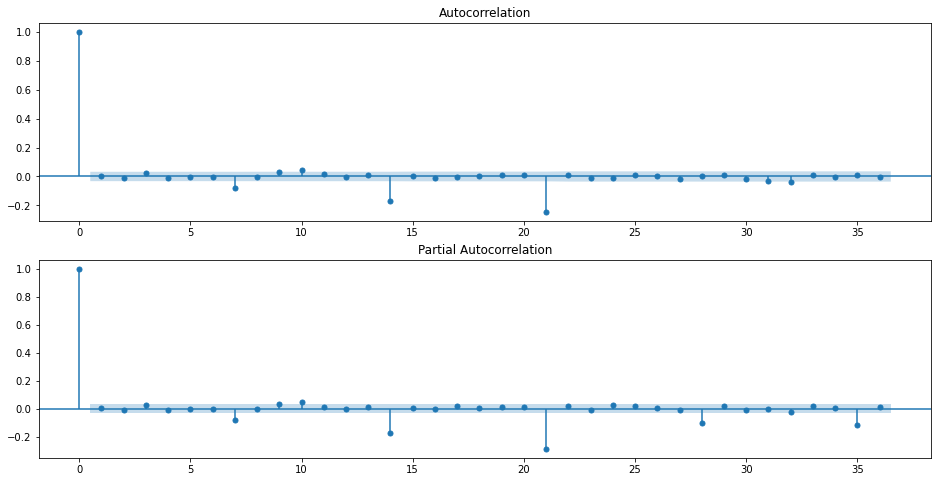

AIC of SARIMA model with order (3,0,0) and seasonal_order (0, 0, 1, 7): -10138.038826392622


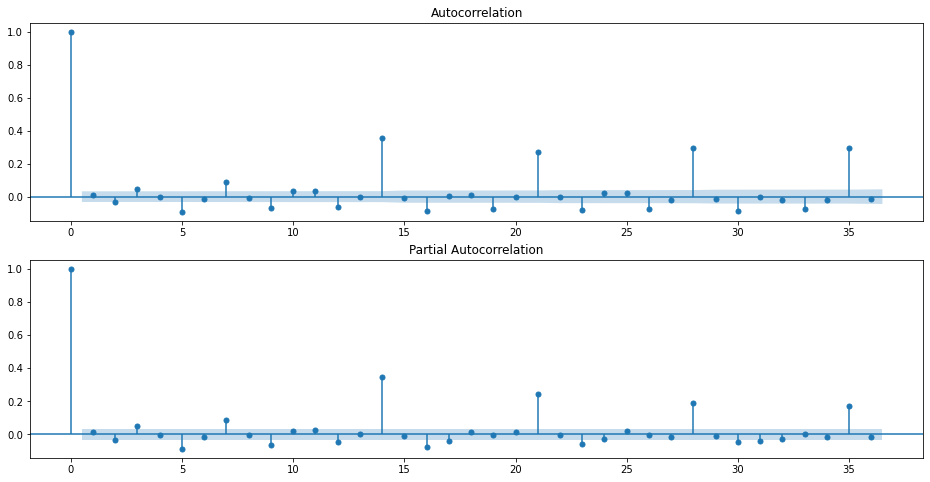

/home/nicsaunier/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


AIC of SARIMA model with order (3,0,0) and seasonal_order (0, 1, 1, 7): -11538.996084651113


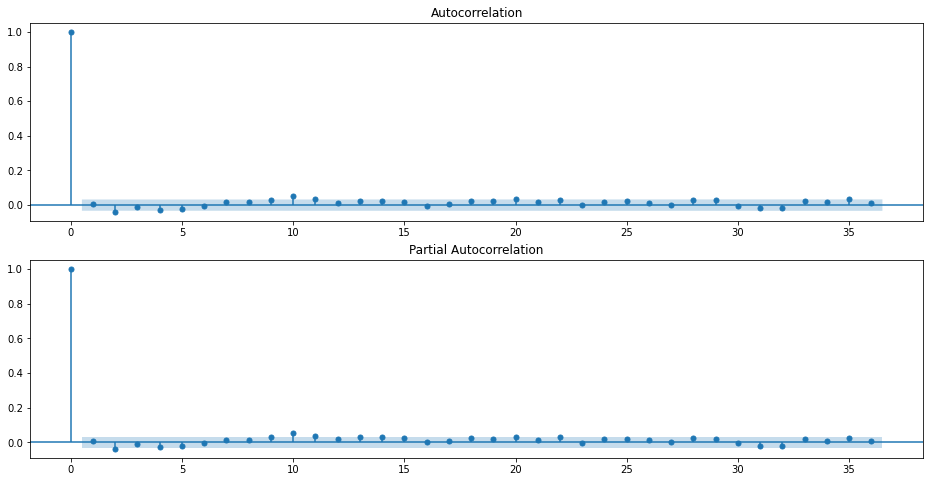

In [26]:
seasonal_orders = [(1,0,0,7), (2,0,0,7), (1,1,0,7), (2,1,0,7), (0,0,1,7), (0,1,1,7)]
for seasonal_order in seasonal_orders:
    model2 = SARIMAX(train['adjusted_elec'], order = (3,0,0), seasonal_order = seasonal_order)
    model2_fit = model2.fit()
    print("AIC of SARIMA model with order (3,0,0) and seasonal_order {}: {}".format(seasonal_order, model2_fit.aic))
    show_acf_plots(model2_fit.resid)

We can see above that the best model seems to be SARIMA (p,d,q= (3,0,0), P,D,Q,s = (0,1,1,7)), both in terms of uncorrelated errors and in terms of AIC. 

The interpretation of the model is the following: 
- On a day to day basis, the model feels a restoring force that moves it back towards its mean (note that the mean here is a detrended moving average of the energy consumption on that day) with some sort of oscillatory pattern.
- on a weekly basis, simple exponential smoothing makes the model better: the variations from expected values of one week are related to those of previous weeks, with more recent weeks counting more.  

Let's now look at the summary statistics for this model:

In [27]:
chosen_model = SARIMAX(train['adjusted_elec'], order = (3,0,0), seasonal_order = (0,1,1,7))
chosen_model_fit = chosen_model.fit()
chosen_model_fit.summary()

/home/nicsaunier/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                       adjusted_elec   No. Observations:                 3652
Model:             SARIMAX(3, 0, 0)x(0, 1, [1], 7)   Log Likelihood                5774.498
Date:                             Mon, 28 Sep 2020   AIC                         -11538.996
Time:                                     10:52:17   BIC                         -11507.991
Sample:                                 01-01-2006   HQIC                        -11527.953
                                      - 12-31-2015                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0722      0.014     77.966      0.000       1.045       1.099
ar.L2         -0.4037      0.019    -21.258      0.000      -0.441      -0.366
ar.L3          0.1196      0.014      8.638      0.000       0.092       0.147
ma.S.L7       -0.9840      0.004   -265.451      0.000      -0.991      -0.977
sigma2         0.0024   4.02e-05     58.606      0.000       0.002       0.002
===================================================================================
Ljung-Box (Q):                       75.98   Jarque-Bera (JB):               420.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

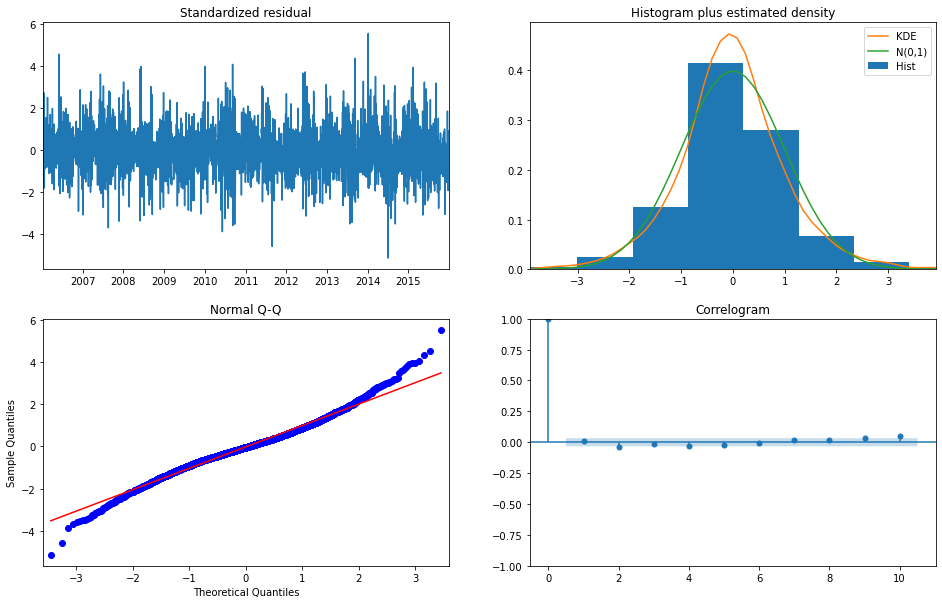

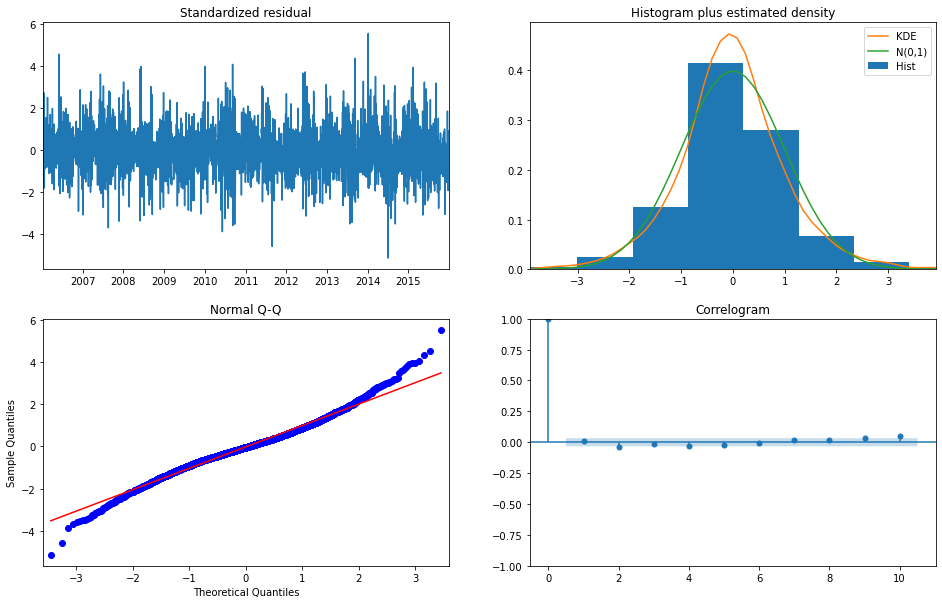

In [28]:
chosen_model_fit.plot_diagnostics(figsize = (16,10))

With these parameters, we've managed to eliminate practically all correlation between model residuals, which is the sign of a model that fits about as well as it can; let's see how it does on the validation set for the years 2016 and 2017.

## Generating forecasts from the model

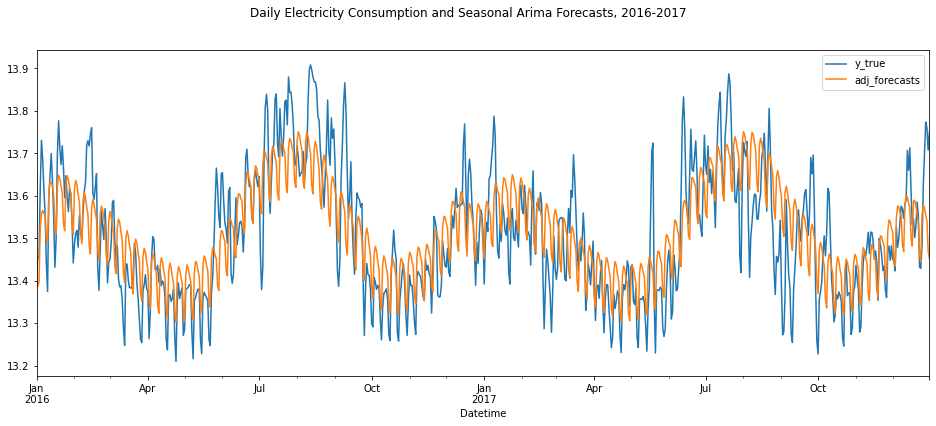

In [29]:

train_preds = chosen_model_fit.forecast(steps=365+366)
#putting the forecasts and the actual values from the test set together in a dataframe
test = test[test.index < '2018-1-1']
validation_df = pd.DataFrame({'y_true': test['log_electric_consumption'], 
                              'adj_value' : test['adjustment_value'], 'unadjusted_forecasts':train_preds})

validation_df['adj_forecasts'] = validation_df['adj_value'] + validation_df['unadjusted_forecasts']

#plotting the results

fig = validation_df.loc[:,['y_true', 'adj_forecasts']].plot(figsize=(16,6)).get_figure()
fig.suptitle('Daily Electricity Consumption and Seasonal Arima Forecasts, 2016-2017')
fig.savefig('SARIMA_preds_daily.png')

 We can see that our predictions are not too bad: while they might miss some of the extreme values, this is exactly what should be expected from a forecasting model in which smoothing is used. Generally, we've captured most of the trend, including weekly trends, without overfitting.

## Looking at model metrics

Let's now measure the Root Mean Squared Error (RMSE) and also Mean Absolute Percentage Error, which according to Professor Nau is sometimes a better measure for time series forecasting.

Note that for Mean Absolute Percentage Error, since our data is currently log transformed, the mean absolute error of the log data should give a good approximation. For Root Mean Squared Error, we need to transform both our test data and our predictions back to their original scale so that the RMSE is in a unit that makes sense.

In [30]:
MAE(validation_df['y_true'], validation_df['adj_forecasts'])

0.0784465057052873

Our predictions on the validation set are off by 8% on average. By comparison, what would be the mean absolute error of the daily trend?

In [31]:
MAE(validation_df['y_true'], validation_df['adj_value'])

0.0893164627452871

We can see that our seasonal ARIMA model has managed to produce predictions that have a lower MAPE (8%) than the baseline predictions with the daily trend (9%).

We now convert the predictions back to MW for measurement of RMSE in real terms.

In [32]:
validation_df['raw_consumption_MW'] = validation_df['y_true'].apply(np.exp)
validation_df['raw_baseline_pred'] = validation_df.adj_value.apply(np.exp)
validation_df['raw_adj_forecast'] = validation_df.adj_forecasts.apply(np.exp)

In [33]:
available_predictions = ['raw_baseline_pred', 'raw_adj_forecast']
for pred in available_predictions:
    print('The root mean squared error for %s is %.2f'%(pred, np.sqrt(mse(y_true=validation_df['raw_consumption_MW'],
                                                                             y_pred = validation_df[pred]))))

The root mean squared error for raw_baseline_pred is 83678.93
The root mean squared error for raw_adj_forecast is 76277.07


## Analysis of Residual Errors

We've reduced mean absolute percentage error from 9% to 8%, and RMSE from 83678 to 76277. Both are notable improvements.

Now, we're going to look at where the biggest errors are, to see if we can find patterns in these errors which might be the results of exogenous variables.

In [34]:
validation_df['weekday'] = validation_df.index.dayofweek
validation_df['month'] = validation_df.index.month

validation_df['percent_error'] = validation_df['adj_forecasts'] - validation_df['y_true']
validation_df['abs_pc_error'] = np.abs(validation_df['percent_error'])

validation_df.head()

,y_true,adj_value,unadjusted_forecasts,adj_forecasts,raw_consumption_MW,raw_baseline_pred,raw_adj_forecast,weekday,month,percent_error,abs_pc_error
Datetime,,,,,,,,,,,
2016-01-01,13.416153,13.561803,-0.139160,13.422643,670751.0,775918.899120,675118.011152,4,1,0.006490,0.006490
2016-01-02,13.453725,13.563140,-0.176006,13.387133,696432.0,776956.562088,651565.619091,5,1,-0.066592,0.066592
2016-01-03,13.457124,13.566296,-0.169466,13.396830,698803.0,779412.582090,657914.242737,6,1,-0.060294,0.060294
2016-01-04,13.618293,13.567962,-0.045326,13.522635,821012.0,780711.971344,746115.196227,0,1,-0.095658,0.095658
2016-01-05,13.730770,13.571149,-0.012063,13.559086,918751.0,783204.294055,773813.272787,1,1,-0.171685,0.171685


#### Errors by day of the week

In [35]:
validation_df.groupby('weekday').percent_error.mean()

weekday
0    0.024831
1    0.032404
2    0.026919
3    0.004833
4   -0.008957
5   -0.006481
6    0.002663
Name: percent_error, dtype: float64

The mean percent error, which adds signed values and not absolute values, is very close to 0 on average, which is a good sign.

In [36]:
validation_df.groupby('weekday').abs_pc_error.mean()

weekday
0    0.075978
1    0.075253
2    0.080115
3    0.072255
4    0.076193
5    0.083591
6    0.085643
Name: abs_pc_error, dtype: float64

MAPE, on the other hand, seems to be slightly larger in the weekend than on weekdays, without the actual electricity consumption being significantly over estimated or underestimated on those days.

#### Errors by month:

In [37]:
validation_df.groupby('month').percent_error.mean()

month
1     0.002346
2     0.021603
3     0.023833
4     0.035720
5     0.029840
6    -0.007314
7    -0.029443
8     0.004627
9     0.011955
10    0.036012
11    0.029033
12   -0.026596
Name: percent_error, dtype: float64

There's a positive mean signed error in 9 out of 12 months, but values are close enough to 0 to not be so concerning

In [38]:
validation_df.groupby('month').abs_pc_error.mean()

month
1     0.074851
2     0.079856
3     0.080287
4     0.053143
5     0.082076
6     0.077831
7     0.088145
8     0.107927
9     0.110145
10    0.065493
11    0.050585
12    0.070421
Name: abs_pc_error, dtype: float64

By far, the biggest absolute percent error is in August and September; most of this error is not due to systematic over or under-estimation, which means something else must be at play. We will investigate that below, but before, we should just check the error by year.

#### Errors by year

In [39]:
validation_df['2016'].abs_pc_error.mean()

0.07432666041708165

In [40]:
validation_df['2017'].abs_pc_error.mean()

0.08257763824085777

While errors are larger in 2017 than in 2016, this is to be expected, as predictions further into the future are necessarily more difficult for the model. The difference is not worrisome.

## A look at the errors in August and September

Here we will look specifically at the months of August and September, which have higher rates of errors than the other months, and see if we can find explanations for those errors.

<AxesSubplot:title={'center':'Real and Predicted Electricity Demand, US East, August 2016'}, xlabel='Datetime'>

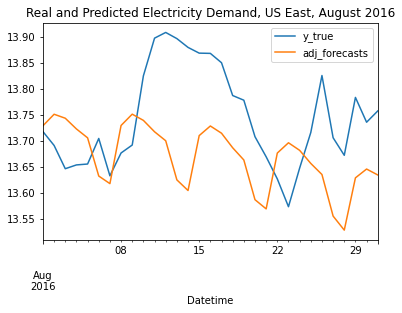

In [41]:
validation_df.loc['August 2016', ['y_true', 'adj_forecasts']].plot(title = 'Real and Predicted Electricity Demand, US East, August 2016')

In [42]:
validation_df['August 2016'].abs_pc_error.mean()

0.11295216419794143

We can see a big spike in true electricity consumption from around August 10th to around August 20th, and again from 24th to the end of the month; let's see if this period corresponds to any extreme heat waves: for this, we can look at weather data from the following website:  
https://www.ncdc.noaa.gov/temp-and-precip/us-maps/1/201608#us-maps-select

As can be seen from screenshots of this website (see below), August 2016 was in fact the hottest on record in many US states, so it's highly likely that the increased electricity demand can be attributed to air conditioning.

<img src = 'images/US_temp_ranks_August16.png' />

### Does temperature also explain the differences observed in September?

<AxesSubplot:title={'center':'Real and Predicted Electricity Demand, US East, September 2016'}, xlabel='Datetime'>

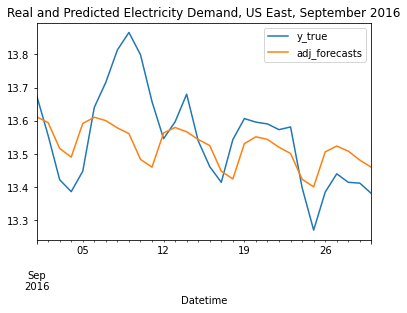

In [43]:
validation_df.loc['September 2016', ['y_true', 'adj_forecasts']].plot(title = 'Real and Predicted Electricity Demand, US East, September 2016')

The difference is less impressive for September 2016: apart from about a week between 5 and 12 September, our predictions for September 2016 don't look so bad; as we can see below, predictions for September 2016 are off by less than 10%, which means predictions for September 2017 were much worse.

In [46]:
validation_df['September 2016'].abs_pc_error.mean()

0.0970643437005912

<AxesSubplot:title={'center':'Real and Predicted Electricity Demand, US East, September 2017'}, xlabel='Datetime'>

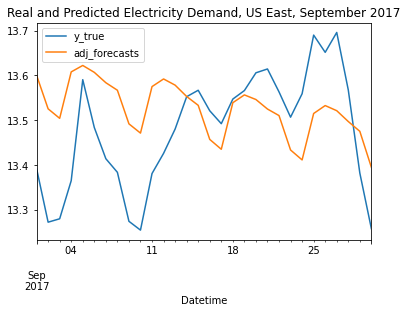

In [44]:
validation_df.loc['September 2017', ['y_true', 'adj_forecasts']].plot(title = 'Real and Predicted Electricity Demand, US East, September 2017')

Differences in September seem to be mostly due to the big dips in electricity consumption in early September 2017. The big dip in the second week of September seems to coincide with Hurricane Irma, which led to big power cuts in Florida and
Georgia, which are part of the PJME zone.
The low consumption on September 2, 3 and 4 cannot be related to Hurricane Irma, but we should investigate if they could be connected to damage from Hurricane Harvey in Texas; if yes, we weould also see very low consumption of electricity in late August. 

<AxesSubplot:title={'center':'Real and Predicted Electricity Demand, US East, August 2017'}, xlabel='Datetime'>

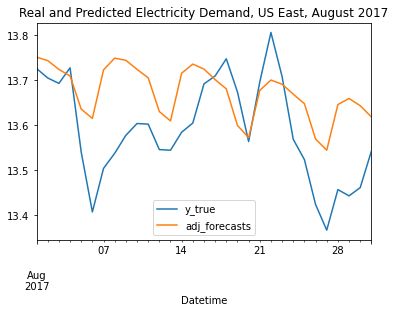

In [45]:
validation_df.loc['August 2017', ['y_true', 'adj_forecasts']].plot(title = 'Real and Predicted Electricity Demand, US East, August 2017')

We do indeed see something happening around August 25, which is when Hurricane Harvey started.

### A look at other big errors made by the model

Below, we look at the worst predictions to see if they can be explained by external causes which are not in the data.

In [47]:
worst_preds = validation_df.abs_pc_error.nlargest(20)
worst_preds.sort_index()

Datetime
2016-02-13    0.235121
2016-02-14    0.281228
2016-05-28    0.233375
2016-07-04    0.241904
2016-08-13    0.271956
2016-08-14    0.275527
2016-09-08    0.234865
2016-09-09    0.304725
2016-09-10    0.315164
2017-01-08    0.240105
2017-05-18    0.272412
2017-05-19    0.305140
2017-06-12    0.224008
2017-06-13    0.247484
2017-09-02    0.253239
2017-09-03    0.224430
2017-09-04    0.243072
2017-12-28    0.219779
2017-12-30    0.237904
2017-12-31    0.298047
Name: abs_pc_error, dtype: float64

We've already seen that errors from  8-10th of September 2016: can be explained by September 2016 being significantly hotter than average, without being the hottest on record to date like August 2016; however, no other explanations come up from an internet search.

#### 18-19 May 2017: 

Looking at the plot below, this looks like an outlier, most likely due to record high temperatures in Florida

<AxesSubplot:title={'center':'Real and Predicted Electricity Demand, US East, May 2017'}, xlabel='Datetime'>

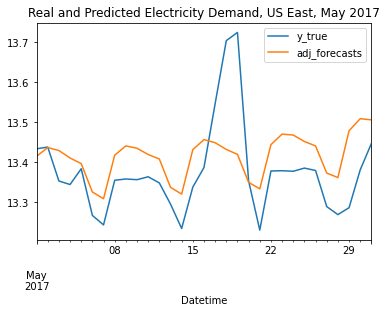

In [48]:
validation_df.loc['May 2017', ['y_true', 'adj_forecasts']].plot(title = 'Real and Predicted Electricity Demand, US East, May 2017')

#### 31st December 2017:
The error is related to the consumption being unusually high for the period. Predictions are very bad for the whole last week of the data, the week between Christmas and New Year. Such a sequence of related errors is likely explained by the weather rather than by the date, see below.


<AxesSubplot:title={'center':'Real and Predicted Electricity Demand, US East, December 2017'}, xlabel='Datetime'>

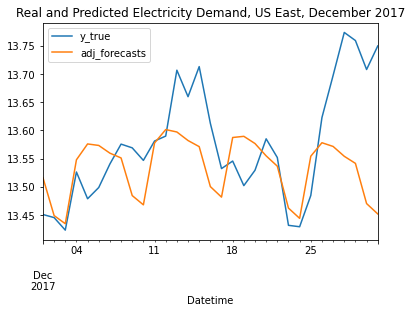

In [49]:
validation_df.loc['December 2017', ['y_true', 'adj_forecasts']].plot(title = 'Real and Predicted Electricity Demand, US East, December 2017')

Looking at 2016 to see what happened then for comparison

<AxesSubplot:title={'center':'Real and Predicted Electricity Demand, US East, December 2016'}, xlabel='Datetime'>

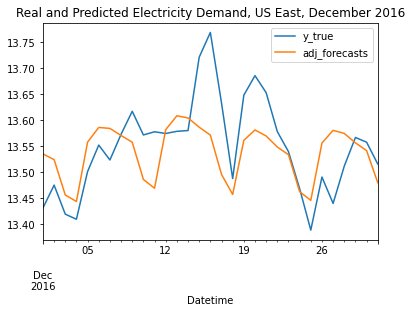

In [50]:
validation_df.loc['December 2016', ['y_true', 'adj_forecasts']].plot(title = 'Real and Predicted Electricity Demand, US East, December 2016')

The plot of December 2016 predictions vs reality confirms that the very high consumption on 31st of December 2017 are an outlier that the model should not be expected to anticipate. The high forecast error could be due to lower than average temperatures in the Northeast and early snow from Christmas on.

#### 14 February 2016; 
The error is interesting as it happens on Valentine's day, which is not a public holiday but nonetheless a special day where we might expect unusual trends like people going out more.

<AxesSubplot:title={'center':'Real and Predicted Electricity Demand, US East, February 2016'}, xlabel='Datetime'>

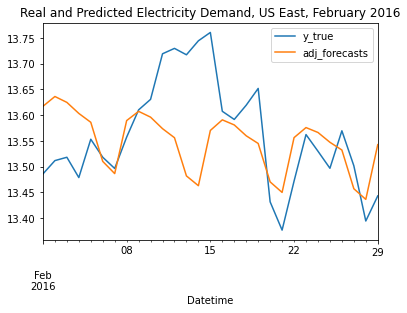

In [51]:
validation_df.loc['February 2016', ['y_true', 'adj_forecasts']].plot(title = 'Real and Predicted Electricity Demand, US East, February 2016')

We can see that the whole week, or at least the period between February 10th and February 15th, was significantly higher than predicted; the error on the 14th seems to be larger than the rest because the 14th was a Sunday, so electricity consumption was predicted to drop. The weather report summary at https://www.ncdc.noaa.gov/sotc/national/201602 mentions unusually cold weather between Feb 10th and Feb 15th, which could be a reason for spikes in electricity consumption.

#### 4th of July 2016 


<AxesSubplot:title={'center':'Real and Predicted Electricity Demand, US East, July 2016'}, xlabel='Datetime'>

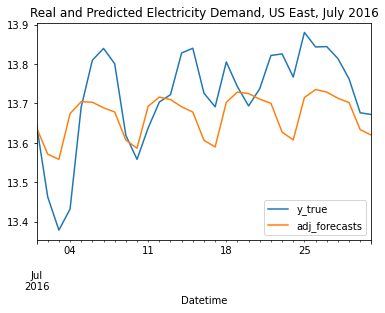

In [52]:
validation_df.loc['July 2016', ['y_true', 'adj_forecasts']].plot(title = 'Real and Predicted Electricity Demand, US East, July 2016')

The error for 4th July 2016 can likely be attributed to the fact that our model does not attempt to fully adjust for holidays: since we smoothed the values by using a rolling mean to extract seasonality from the series, the expected decrease for 4th of July cannot be properly accounted for. 
Note that in terms of electricity consumption, not all holidays matter equally, and 4th of July seems to have more impact than other holidays. However, accounting for the specificity of each individual holiday in our model would mean encoding each specific holiday as a variable.

### Saving predictions for future comparison with other models

In [53]:
validation_df.raw_adj_forecast.to_csv('data/processed/Sarima_predictions.csv')